# Setup Environment

In [33]:
import pandas as pd
import numpy as np
from numpy import mean, std
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc, make_scorer, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import joblib
import shap

# Modelling

## Read Data

In [2]:
# Load intermediate dataset
data = pd.read_csv("Cleaned data/finalised_data.csv", index_col='Transaction ID')

In [3]:
data.head()

,Transaction Amount,Quantity,Customer Age,Is Fraudulent,Account Age Days,Transaction Hour,Age Group,Transaction Values Ordinal,Log Transaction Amount,Transaction Day_of_month,...,Proxy_True,Proxy_Unknown,Customer Life_stage_Teenage,Customer Life_stage_Young Adult,Customer Life_stage_Working Adult,Customer Life_stage_Middle-Aged,Customer Life_stage_Senior,Transaction Phase_of_month_Start,Transaction Phase_of_month_Middle,Transaction Phase_of_month_End
Transaction ID,,,,,,,,,,,,,,,,,,,,,
c12e07a0-8a06-4c0d-b5cc-04f3af688570,42.32,1,40,0,282,23,5,1,3.768614,24,...,False,False,False,False,True,False,False,False,False,True
7d187603-7961-4fce-9827-9698e2b6a201,301.34,3,35,0,223,0,4,3,5.711552,22,...,False,False,False,False,True,False,False,False,False,True
f2c14f9d-92df-4aaf-8931-ceaf4e63ed72,340.32,5,29,0,360,8,3,3,5.832820,22,...,False,False,False,True,False,False,False,False,False,True
e9949bfa-194d-486b-84da-9565fca9e5ce,95.77,5,45,0,325,20,5,1,4.572337,16,...,False,False,False,False,False,True,False,False,True,False
7362837c-7538-434e-8731-0df713f5f26d,77.45,5,42,0,116,15,5,1,4.362461,16,...,False,False,False,False,True,False,False,False,True,False


In [4]:
data.columns

Index(['Transaction Amount', 'Quantity', 'Customer Age', 'Is Fraudulent',
       'Account Age Days', 'Transaction Hour', 'Age Group',
       'Transaction Values Ordinal', 'Log Transaction Amount',
       'Transaction Day_of_month', 'Transaction During_weekend',
       'addressesMatch', 'isPOBox', 'Payment Method_PayPal',
       'Payment Method_bank transfer', 'Payment Method_credit card',
       'Payment Method_debit card', 'Product Category_clothing',
       'Product Category_electronics', 'Product Category_health & beauty',
       'Product Category_home & garden', 'Product Category_toys & games',
       'Device Used_desktop', 'Device Used_mobile', 'Device Used_tablet',
       'ipAddressMatchesUS_False', 'ipAddressMatchesUS_True',
       'ipAddressMatchesUS_Unknown', 'Transaction Time_of_day_Night',
       'Transaction Time_of_day_Morning', 'Transaction Time_of_day_Afternoon',
       'Transaction Time_of_day_Evening', 'Transaction Day_of_week_0',
       'Transaction Day_of_week_1', 'T

### Handling similar columns

To prevent multicollinearity, multiple columns that represent customer ages in bins have to be seperated from each other.

Customer Life stage, Age Group and Customer Age have to be seperated.

Transaction Amount, Log Transaction Amount and Transaction Values Ordinal have to be separated as well.

In [5]:
# Splitting the age group categories
life_stage_cols = ['Customer Life_stage_Teenage', 'Customer Life_stage_Young Adult', 
                   'Customer Life_stage_Working Adult', 'Customer Life_stage_Middle-Aged', 
                   'Customer Life_stage_Senior']

data.drop(columns=life_stage_cols, inplace=True)
# data.drop(columns='Customer Age', inplace=True)
data.drop(columns='Age Group', inplace=True)

# Handling transaction amounts duplicate columns
data.drop(columns='Transaction Amount', inplace=True)
data.drop(columns='Transaction Values Ordinal', inplace=True)
# data.drop(columns='Log Transaction Amount', inplace=True)

### Convert boolean columns to integers for SHAP

In [6]:
# Convert boolean columns to 0 and 1
boolean_columns = data.select_dtypes(include=bool).columns
data[boolean_columns] = data[boolean_columns].astype(int)

## Train Test Split

In [7]:
# Train test split
X = data.loc[:, data.columns != 'Is Fraudulent']
y = data["Is Fraudulent"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=1, stratify=y)


# Model Creation and Evaluation


## Evaluate function of models

In [8]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def evaluate_model(model, param_grid, cv):
    # Define samplers
    undersampler = RandomUnderSampler(random_state=1)
    smote = SMOTE(random_state=1)

    # # Create pipeline with samplers
    # pipeline = Pipeline(steps=[('undersampler', undersampler), ('classifier', model)])
    # pipeline = Pipeline(steps=[('smote', smote), ('classifier', model)])
    pipeline = Pipeline(steps=[('undersampler', undersampler), ('smote', smote), ('classifier', model)])

    # Define grid search
    grid_search = GridSearchCV(pipeline, param_grid, 
                          scoring='recall', cv=cv, n_jobs=-1,
                          verbose=0)
    # Fit the grid search to the train data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Print the best training pr_auc
    print(f"\nResults on {model.__class__.__name__} model")
    print(f"\nBest training Recall score: {best_score}")

    # Create best model on the whole train data
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Predict on the test data
    # y_scores = best_model.predict_proba(X_test)[:, 1]
    y_pred = best_model.predict(X_test)

    # Create the confusion matrix and output evaluation metrics
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    recall = recall_score(y_test, y_pred)
    print("Test Recall Score:", recall)

    precision = precision_score(y_test, y_pred)
    print("Test Precision Score:", precision)

    f1 = f1_score(y_test, y_pred)
    print("Test F1 Score:", f1)

    return best_params

### Running grid search and k-fold cross validation

In [35]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define the parameter grid for grid search
# Takes 210mins to run

param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4, 8],
    'classifier__class_weight': ['balanced']
}

param_grid_xgb = {
    'classifier__max_depth': [5, 10, 15, 20],
    'classifier__learning_rate': [0.1, 0.05, 0.01, 0.001],
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__reg_alpha': [0, 0.1, 0.5],
    'classifier__reg_lambda': [1, 1.5, 2],  
}

rf = evaluate_model(RandomForestClassifier(), 
                    param_grid_rf, cv)

xgb = evaluate_model(XGBClassifier(), 
                     param_grid_xgb, cv)



Results on RandomForestClassifier model

Best training Recall score: 0.7845992005049442
Confusion Matrix:
 [[3277 1204]
 [  49  195]]
Test Recall Score: 0.7991803278688525
Test Precision Score: 0.139385275196569
Test F1 Score: 0.23737066342057211

Results on XGBClassifier model

Best training Recall score: 0.7948032821375973
Confusion Matrix:
 [[3145 1336]
 [  43  201]]
Test Recall Score: 0.8237704918032787
Test Precision Score: 0.13077423552374756
Test F1 Score: 0.2257158899494666


In [36]:
# Show the best params
print("\nBest parameters for Random Forest:", rf)
print("\nBest parameters for XGBoost:", xgb)


Best parameters for Random Forest: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}

Best parameters for XGBoost: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.001, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__reg_alpha': 0.5, 'classifier__reg_lambda': 2, 'classifier__subsample': 0.6}


### Loading best models and saving them

In [85]:
# Load best models and their parameters
param_grid_rf_best = {
    'max_depth': 10,
    'min_samples_leaf': 8,
    'min_samples_split': 10,
    'n_estimators': 300,
    'class_weight': 'balanced'
}

param_grid_xgb_best = {
    'colsample_bytree': 0.6,
    'learning_rate': 0.001,
    'max_depth': 5,
    'n_estimators': 200,
    'reg_alpha': 0.5,
    'reg_lambda': 2,
    'subsample': 0.6
}

undersampler = RandomUnderSampler(random_state=1)
smote = SMOTE(random_state=1)

# Establish the best model for Random Forest
best_rf = RandomForestClassifier()
best_rf.set_params(**param_grid_rf_best)

pipeline_rf = Pipeline(steps=[('undersampler', undersampler), ('smote', smote), ('classifier', best_rf)])
pipeline_rf.fit(X_train, y_train)
joblib.dump(pipeline_rf, "Models/Best_RandomForest_model.pkl")

y_pred_rf = pipeline_rf.predict(X_test)
y_scores_rf = pipeline_rf.predict_proba(X_test)[:, 1]

print("\nTest Results on Random Forest model")
# Create the confusion matrix and evaluation metrics
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm_rf)

recall_rf = recall_score(y_test, y_pred_rf)
print("Test Recall Score:", recall_rf)

precision_rf = precision_score(y_test, y_pred_rf)
print("Test Precision Score:", precision_rf)

f1_rf = f1_score(y_test, y_pred_rf)
print("Test F1 Score:", f1_rf)

roc_auc_rf = roc_auc_score(y_test, y_scores_rf)
print("ROC AUC:", roc_auc_rf)

# Establish the best model for XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**param_grid_xgb_best)

pipeline_xgb = Pipeline(steps=[('undersampler', undersampler), ('smote', smote), ('classifier', best_xgb)])
pipeline_xgb.fit(X_train, y_train)
joblib.dump(pipeline_xgb, "Models/Best_XGBoost_model.pkl")

y_pred_xgb = best_xgb.predict(X_test)
y_scores_xgb = best_xgb.predict_proba(X_test)[:, 1]

print("\nTest Results on XGBoost model")
# Create the confusion matrix and evaluations metrics
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", cm_xgb)

recall_xgb = recall_score(y_test, y_pred_xgb)
print("Test Recall Score:", recall_xgb)

precision_xgb = precision_score(y_test, y_pred_xgb)
print("Test Precision Score:", precision_xgb)

f1_xgb = f1_score(y_test, y_pred_xgb)
print("Test F1 Score:", f1_xgb)

roc_auc_xgb = roc_auc_score(y_test, y_scores_xgb)
print("ROC AUC:", roc_auc_xgb)


Test Results on Random Forest model
Confusion Matrix:
 [[3254 1227]
 [  47  197]]
Test Recall Score: 0.8073770491803278
Test Precision Score: 0.13834269662921347
Test F1 Score: 0.23621103117505995
ROC AUC: 0.8258841520298821

Test Results on XGBoost model
Confusion Matrix:
 [[3145 1336]
 [  43  201]]
Test Recall Score: 0.8237704918032787
Test Precision Score: 0.13077423552374756
Test F1 Score: 0.2257158899494666
ROC AUC: 0.8315483224251027


## Stacking Classifier

In [86]:
# Create stack classifier
stack_model = StackingClassifier(estimators=[('rf', pipeline_rf), ('xgb', pipeline_xgb)],
                                 final_estimator=LogisticRegression(),
                                 cv=10, stack_method='auto',
                                 n_jobs=-1,
                                 )

stack_model.fit(X_train, y_train)

y_scores = stack_model.predict_proba(X_test)[:, 1]
# y_pred = stack_model.predict(X_test)

y_pred = (y_scores > 0.04).astype(int)

print(f"\nTest Results on Stack model")
# Create the confusion matrix and evaluation metrics
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

recall = recall_score(y_test, y_pred)
print("Test Recall Score:", recall)
precision = precision_score(y_test, y_pred)
print("Test Precision Score:", precision)
f1 = f1_score(y_test, y_pred)
print("Test F1 Score:", f1)
roc_auc = roc_auc_score(y_test, y_scores)
print("ROC AUC:", roc_auc)



Test Results on Stack model
Confusion Matrix:
 [[3040 1441]
 [  39  205]]
Test Recall Score: 0.8401639344262295
Test Precision Score: 0.12454434993924667
Test F1 Score: 0.21693121693121692
ROC AUC: 0.8299203193081168


## SHAP Explainer for Random Forest

(4725, 41, 2)


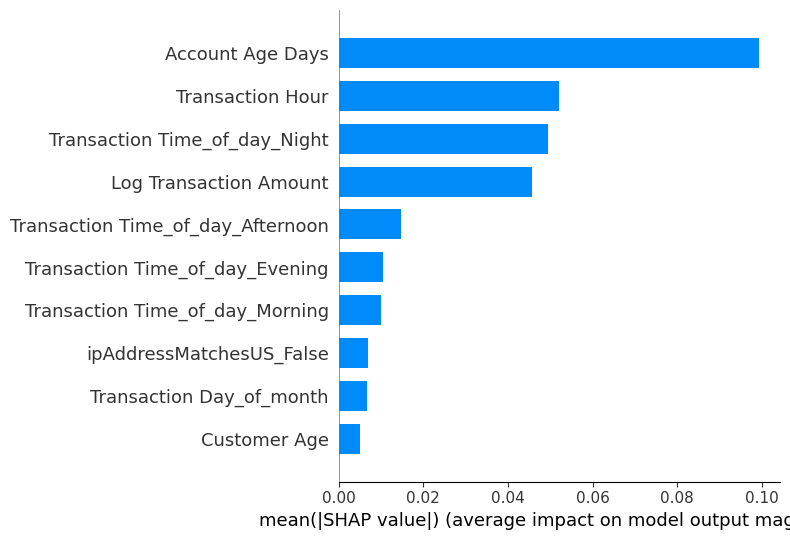

In [81]:
explainer = shap.TreeExplainer(pipeline_rf['classifier'])
shap_values = explainer(X_test)

print(shap_values.shape)
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type='bar', max_display=10)

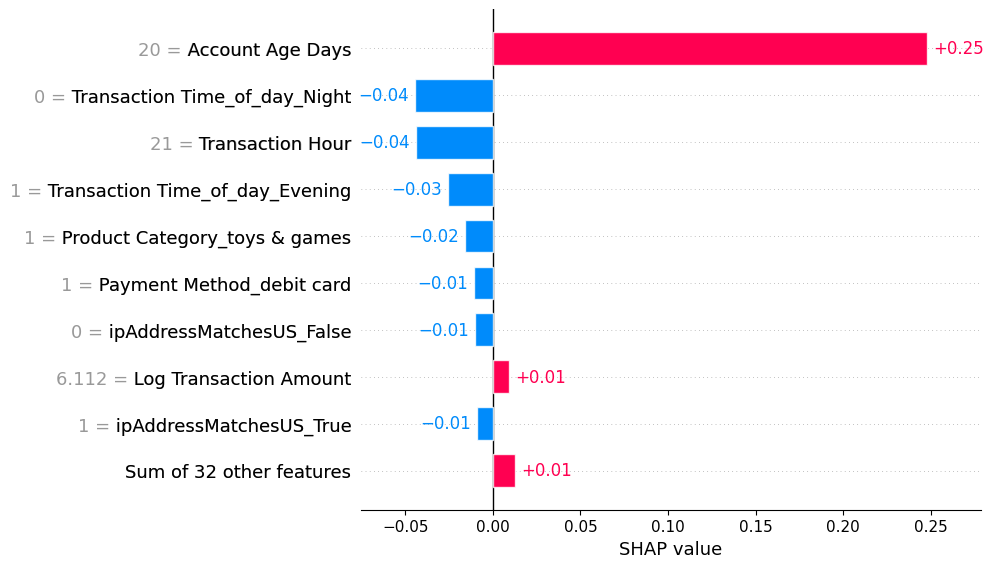

In [82]:
shap.plots.bar(shap_values[1,:,1])

### Local SHAP Representation for Random Forest

## SHAP Explainer for XGBoost

(4725, 41)


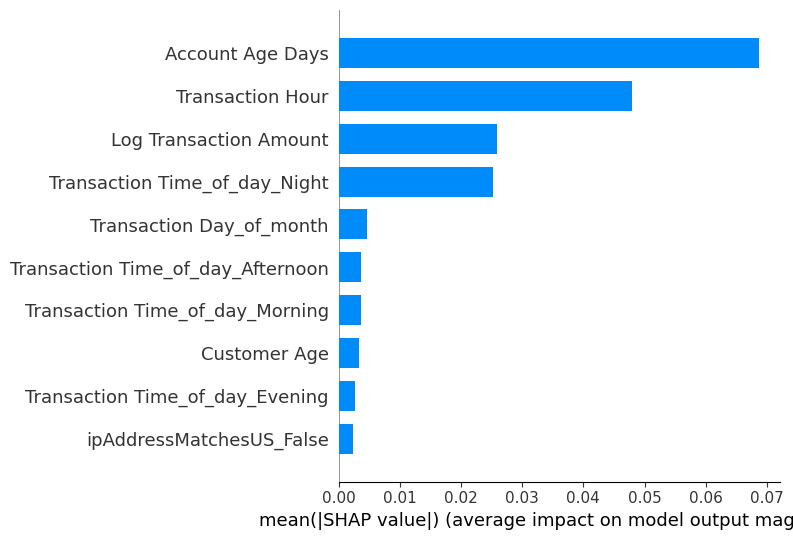

In [83]:
explainer = shap.TreeExplainer(pipeline_xgb['classifier'])
shap_values = explainer(X_test)

print(shap_values.shape)
# shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=10)

### Local SHAP Representation for XGBoost

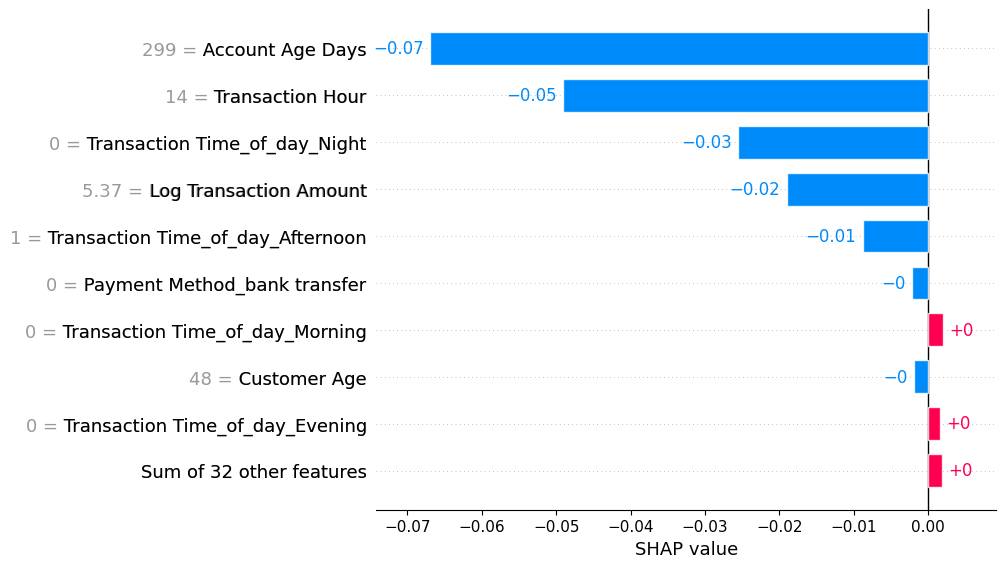

In [84]:
shap.plots.bar(shap_values[0])